# Full Explainability Example
Lewis Cole 2023

In [1]:
# Import libs
import numpy as np
import pandas as pd

# For Plotting (not for production)
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier as LGBM

# For explainability 
import wittgenstein as lw
from alibi.explainers import ALE, AnchorTabular, CounterfactualProto
from sklearn.isotonic import IsotonicRegression as IR
from pyod.models.copod import COPOD as COP
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import NearestNeighbors
import shap
from lightgbm import LGBMRegressor  # Used for shap
from scipy.stats import beta
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef, f1_score, precision_recall_curve, roc_curve # For CV Stats

C:\Users\BoxIt\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Import Data

In [2]:
df = pd.read_csv('credit_default_data.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

from sklearn.preprocessing import LabelEncoder

# Adjust cat columns to range from 0
df[cat_cols] = df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

In [4]:
X = df.drop(columns=['default'])
y = df['default']

In [5]:
# Set categorical columns to type category
for c in cat_cols:
    X[c] = X[c].astype('category')

In [6]:
# Split into inference and training splits
X_train, X_inf, y_train, y_inf = train_test_split(X, y, test_size=0.25, random_state=123)

# Split Train into train test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

In [7]:
X_train = X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
X_inf = X_inf.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)
y_inf = y_inf.reset_index(drop=True)

## Train Model

In [8]:
clf = LGBM(random_state=123, 
           importance_type='gain')

clf.fit(X_train, y_train)

LGBMClassifier(importance_type='gain', random_state=123)

In [9]:
# Train model Stats

print("Number of Features:", X_train.shape[1])
print("Number Continuous Features:", X_train.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train.shape[0])
print("Number Positive Train Examples:", (y_train == 1).sum())
print("Number Negative Train Examples:", (y_train == 0).sum())

Number of Features: 23
Number Continuous Features: 14
Number Categorical Features: 9
Number Train Examples: 16875
Number Positive Train Examples: 3741
Number Negative Train Examples: 13134


### Conformal Prediction

In [10]:
# Get Scores
clf_test_score = clf.predict_proba(X_test)[:,1]

In [11]:
# Conformal Prediction Curve
n_grid = 1001
clf_score_grid = np.linspace(0,1,n_grid)
p0_score_grid = np.zeros(n_grid)
p1_score_grid = np.zeros(n_grid)

i = 0
for score in clf_score_grid:
    cal_scores = np.append(clf_test_score, score)
    
    # p0 calc
    ir = IR()
    labels = np.append(y_test, 0)
    ir.fit(cal_scores, labels)
    p0_score_grid[i] = ir.predict(np.array([score]))
    
    # p1 calc
    ir = IR()
    labels = np.append(y_test, 1)
    ir.fit(cal_scores, labels)
    p1_score_grid[i] = ir.predict(np.array([score]))
    
    i = i + 1
    
p_score_grid = p1_score_grid / (1 - p0_score_grid + p1_score_grid)
unc_score_grid = p1_score_grid - p0_score_grid

In [12]:
def predict_proba(X_):
    """
    Create function overload for predict proba method
    based on conformal predictor
    """
    base_scores = clf.predict_proba(X_)[:,1]
    adj_scores = np.interp(base_scores, clf_score_grid, p_score_grid)
    
    out_scores = np.zeros((base_scores.shape[0], 2))
    out_scores[:,0] = 1 - adj_scores
    out_scores[:,1] = adj_scores
    
    return out_scores

prob_scores_inf = predict_proba(X_inf)

In [13]:
def predict_proba_numpy(X_):
    """
    Create predict function to parse dtypes correctly
    """
    df = pd.DataFrame(X_, columns=X.columns)
    
    for c in df.columns:
        df[c] = df[c].astype(X[c].dtype)
        
    return predict_proba(df)

In [14]:
def uncertain_score(X_):
    """
    Create function to evaluate uncertainty
    """
    base_scores = clf.predict_proba(X_)[:,1]
    adj_scores = np.interp(base_scores, clf_score_grid, unc_score_grid)
    
    return adj_scores

unc_scores_inf = uncertain_score(X_inf)

In [15]:
# OOD prediction

ood = COP()
ood.fit(X_train)
ood_test = ood.predict_proba(X_test)[:,1]
ood_inf = ood.predict_proba(X_inf)[:,1]

qt = QuantileTransformer()
qt.fit(ood_test.reshape(-1,1))

ood_scores_inf = qt.transform(ood_inf.reshape(-1,1))

# Global Explainability

## Rules Explainer

In [16]:
# Apply arbitrary threshold to prob to give "risks"
thresh = 0.5

test_model_risks = (predict_proba(X_test)[:,1] > thresh)*1

In [17]:
rip_exp = lw.RIPPER(random_state=123, max_rules=10, max_rule_conds=10, max_total_conds=50)
rip_exp.fit(X_test, y=test_model_risks, pos_class=1)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [18]:
rip_exp.fit(X_test, y=test_model_risks, pos_class=1)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [19]:
rip_exp.out_model()

[[PAY_0=4] V
[PAY_2=4 ^ PAY_6=3] V
[PAY_2=4 ^ PAY_0=5] V
[PAY_5=3 ^ PAY_0=3 ^ PAY_6=3]]


In [20]:
# Accuracy on all data
(rip_exp.predict(X_test) == test_model_risks).sum() / test_model_risks.shape[0]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.9713777777777778

In [21]:
# Precision for positive class
df_pos = X_test.reset_index()[test_model_risks == 1]

(np.array(rip_exp.predict(df_pos))).sum() / df_pos.shape[0]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.8398835516739447

In [22]:
# Precision for negative class
df_neg = X_test.reset_index()[test_model_risks == 0]

(~np.array(rip_exp.predict(df_neg))).sum() / df_neg.shape[0]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.9898744430943702

## ALE

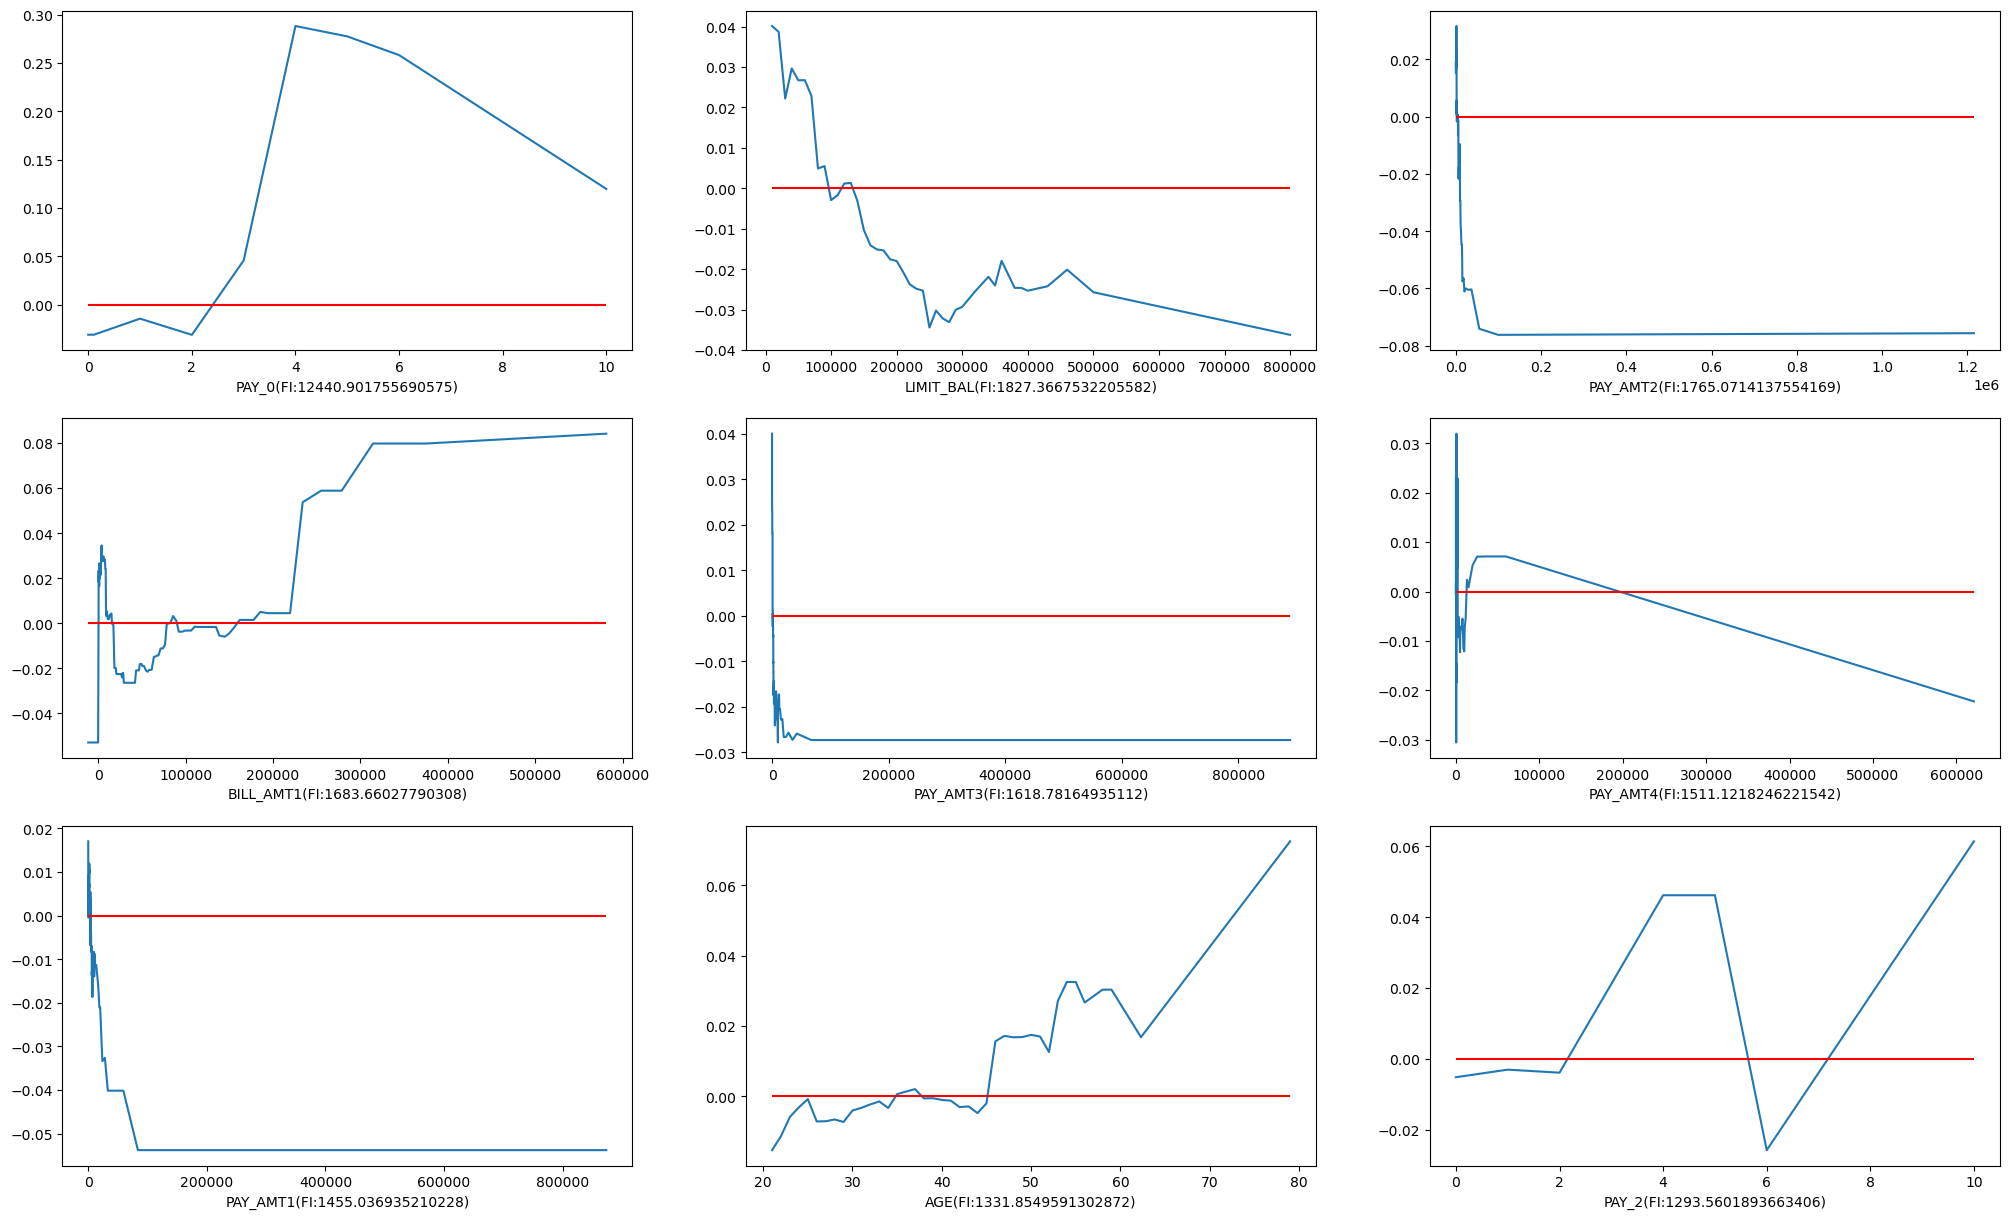

In [23]:
# Control number features to plot
n_ales = 9

# Select based on feature importances
feat_idx = np.argsort(clf.feature_importances_)[-n_ales:][::-1]

# Initialize ALE and get explainers
ale = ALE(predict_proba_numpy, feature_names=X.columns.to_list(), target_names=['0','1'])
ale_exp = ale.explain(X_test.to_numpy())

# Get plot grid size
import math
plot_grid_size = math.floor(math.sqrt(n_ales))

fig, ax = plt.subplots(plot_grid_size, plot_grid_size, figsize=(25, 15))

for i in range(plot_grid_size):
    for j in range(plot_grid_size):
        idx = plot_grid_size*i + j
        ale_val = ale_exp.ale_values[feat_idx[idx]][:,1]
        feat_val = ale_exp.feature_values[feat_idx[idx]]
        feat_name = ale_exp.feature_names[feat_idx][idx]
        
        ax[i,j].plot(feat_val, ale_val)
        ax[i,j].hlines(y=0, xmin=feat_val.min(), xmax=feat_val.max(), colors='r')
        ax[i,j].set_xlabel(feat_name+"(FI:"+str(clf.feature_importances_[feat_idx[idx]])+")")

plt.show()

## Cross-Validated Results

In [24]:
def cv_loop(n_loops, X_, y_, split):
    thresh_ = 0.5
    
    auc = []
    avg_pr = []
    matc = []
    f1 = []
    fpr = []
    
    for _ in range(n_loops): 
        X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=split)

        temp_clf = LGBM()
        temp_clf.fit(X_train_, y_train_)

        temp_preds = temp_clf.predict_proba(X_test_)[:,1]

        auc.append(roc_auc_score(y_test_, temp_preds))
        avg_pr.append(average_precision_score(y_test_, temp_preds))
        matc.append(matthews_corrcoef(y_test_, (temp_preds>thresh_)*1))
        f1.append(f1_score(y_test_, (temp_preds>thresh_)*1))

        fpr_thresh = np.min(temp_preds[y_test_ == 1])
        fpr_temp = (temp_preds[y_test_ == 0] < fpr_thresh).sum() / (y_test_ == 0).sum()
        fpr.append(fpr_temp)

    auc = np.array(auc)
    avg_pr = np.array(avg_pr)
    matc = np.array(matc)
    f1 = np.array(f1)
    fpr = np.array(fpr)
    
    aves = np.array([auc.mean(), avg_pr.mean(), matc.mean(), f1.mean(), fpr.mean()])
    stds = np.array([auc.std(), avg_pr.std(), matc.std(), f1.std(), fpr.std()])
    
    out_dict = {'Statistic': ['AUC', 'AVG_PREC', 'MATH_CORR', 'F1', 'FPR_(RECALL=1)'],
                'Mean': aves,
                'Std': stds}
    
    return pd.DataFrame(out_dict).set_index('Statistic')

In [25]:
cv_df = cv_loop(30, X_train, y_train, split=0.33)
cv_df

,Mean,Std
Statistic,,
AUC,0.775800,0.005596
AVG_PREC,0.554361,0.012408
MATH_CORR,0.404656,0.014870
F1,0.480843,0.012014
FPR_(RECALL=1),0.008536,0.006250


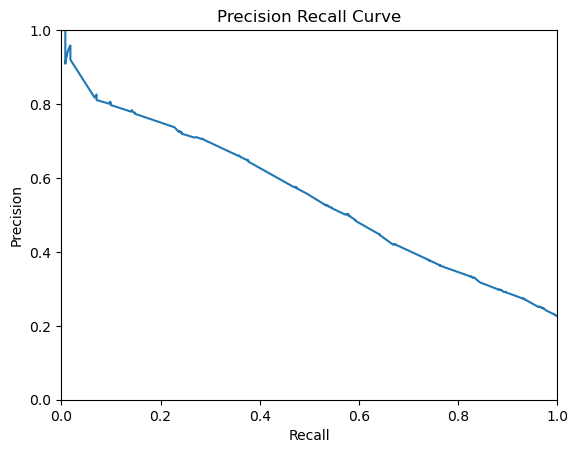

In [26]:
precision, recall, threshold = precision_recall_curve(y_test, predict_proba(X_test)[:,1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

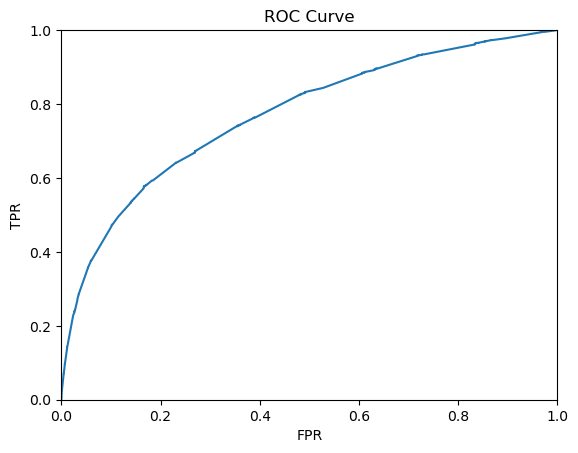

In [27]:
fpr, tpr, thresh = roc_curve(y_test, predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

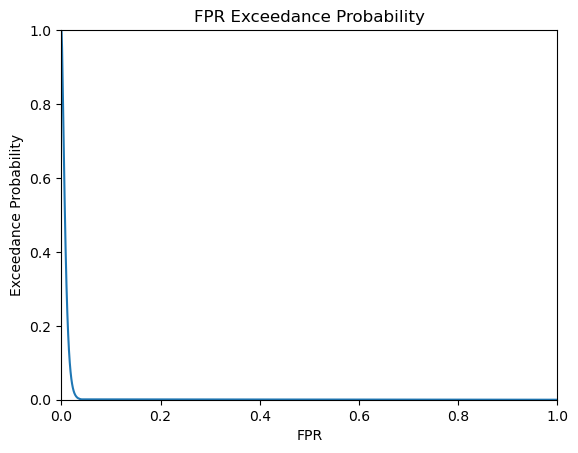

In [28]:
# FPR Exceedance Probability plots

EP = np.linspace(0,1,1001)

mu = cv_df.loc['FPR_(RECALL=1)', 'Mean']
sig = cv_df.loc['FPR_(RECALL=1)', 'Std']

a = (mu**2*(1-mu)-sig**2*mu)/(sig**2)
b = a*(1 - mu)/mu

fpr_ep = beta.ppf(1-EP, a, b)

plt.plot(fpr_ep, EP)
plt.xlabel('FPR')
plt.ylabel('Exceedance Probability')
plt.title('FPR Exceedance Probability')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Local Explainability

In [29]:
# Select id to explain

inf_id = np.argsort(prob_scores_inf[:,1])[7250]

prob_scores_inf[:,1][inf_id]

0.7307692307692307

In [30]:
# Apply threshold for prediction

thresh = 0.5

pred_label = 1 if prob_scores_inf[:,1][inf_id] > thresh else 0
pred_label

1

## Reliability Context

In [31]:
prob_score = prob_scores_inf[:,1][inf_id]
unc_score = unc_scores_inf[inf_id]
ood_score = ood_scores_inf[inf_id][0]

print("Probability of Risk:", prob_score)
print("Uncertainty In Probability:", unc_score)
print("OOD Probability:", ood_score)

Probability of Risk: 0.7307692307692307
Uncertainty In Probability: 0.012987012987013102
OOD Probability: 0.8172698288801228


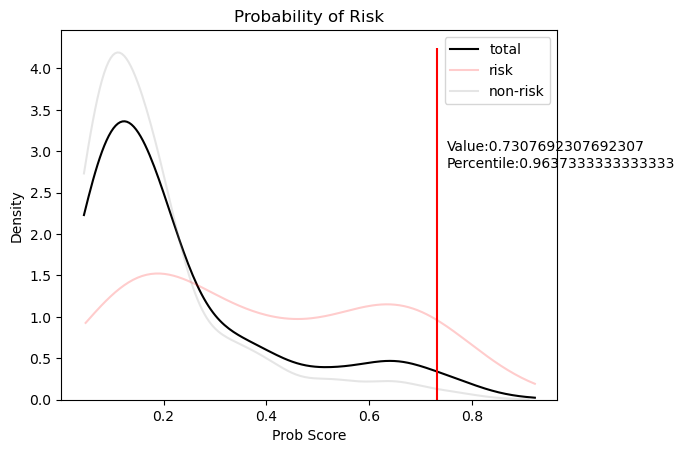

In [90]:
pct = (prob_score > prob_scores_inf[:,1]).sum() / prob_scores_inf.shape[0]

sns.kdeplot(prob_scores_inf[:,1], bw_adjust=2, clip=[0,1], cut=0, label='total', color='black')
sns.kdeplot(prob_scores_inf[y_inf == 1][:,1], bw_adjust=2, clip=[0,1], cut=0, label='risk', color='red', alpha=0.2)
sns.kdeplot(prob_scores_inf[y_inf == 0][:,1], bw_adjust=2, clip=[0,1], cut=0, label='non-risk', color='gray', alpha=0.2)
plt.title('Probability of Risk')
plt.xlabel('Prob Score')
plt.vlines(x=prob_score, ymin=0, ymax=4.25, color='r')
plt.annotate('Percentile:'+str(pct), xy=(0.75,2.8))
plt.annotate('Value:'+str(prob_score), xy=(0.75,3))
plt.legend()
plt.show()

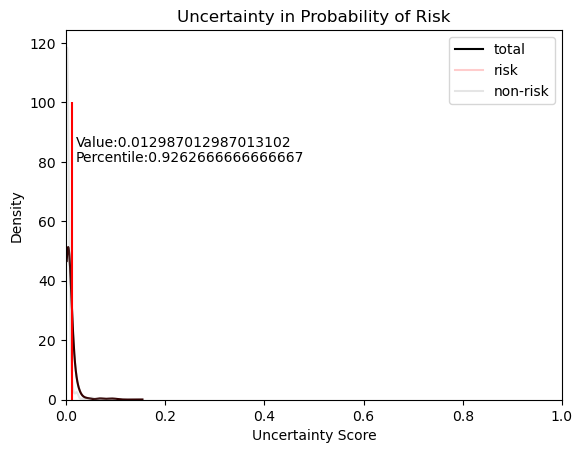

In [89]:
pct = (unc_score > unc_scores_inf).sum() / unc_scores_inf.shape[0]

sns.kdeplot(unc_scores_inf[y_inf == 1], bw_adjust=2, clip=[0,1], cut=0, label='total', color='black')
sns.kdeplot(unc_scores_inf[y_inf == 1], bw_adjust=2, clip=[0,1], cut=0, label='risk', color='red', alpha=0.2)
sns.kdeplot(unc_scores_inf[y_inf == 0], bw_adjust=2, clip=[0,1], cut=0, label='non-risk', color='gray', alpha=0.2)
plt.title('Uncertainty in Probability of Risk')
plt.xlabel('Uncertainty Score')
plt.vlines(x=unc_score, ymin=0, ymax=100, color='r')
plt.annotate('Percentile:'+str(pct), xy=(0.02,80))
plt.annotate('Value:'+str(unc_score), xy=(0.02,85))
plt.xlim((0,1))
plt.legend()
plt.show()

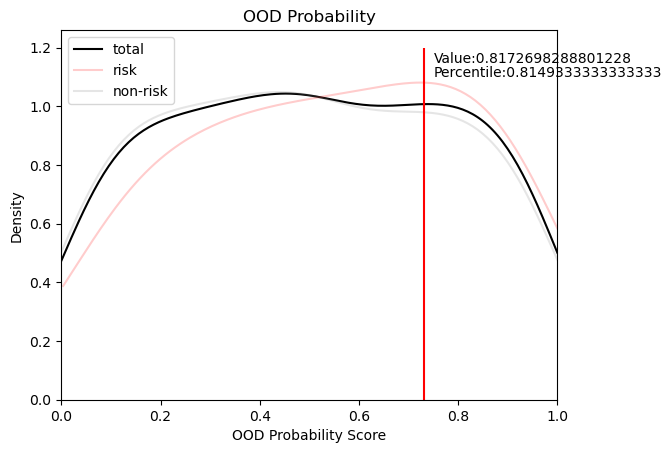

In [91]:
pct = (ood_score > ood_scores_inf).sum() / ood_scores_inf.shape[0]

sns.kdeplot(ood_scores_inf.ravel(), bw_adjust=2, clip=[0,1], cut=0, label='total', color='black')
sns.kdeplot(ood_scores_inf.ravel()[y_inf == 1], bw_adjust=2, clip=[0,1], cut=0, label='risk', color='red', alpha=0.2)
sns.kdeplot(ood_scores_inf.ravel()[y_inf == 0], bw_adjust=2, clip=[0,1], cut=0, label='non-risk', color='gray', alpha=0.2)
plt.title('OOD Probability')
plt.xlabel('OOD Probability Score')
plt.vlines(x=prob_score, ymin=0, ymax=1.2, color='r')
plt.annotate('Percentile:'+str(pct), xy=(0.75,1.1))
plt.annotate('Value:'+str(ood_score), xy=(0.75,1.15))
plt.xlim((0,1))
plt.legend(loc='upper left')
plt.show()

## Anchor

In [35]:
# Have to make map for categorical columns
# Category map is a dict of the form:
# key = column index (not name)
# values = values taken by that column

cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
n_cols = X.columns.shape[0]

category_map = {}

for i in range(len(cat_cols)):
    col = cat_cols[i]
    col_id = np.arange(n_cols)[X.columns == cat_cols[i]][0]
    vals = X[col].sort_values().astype('str').unique().tolist()
    
    category_map[col_id] = vals

category_map

{1: ['0', '1'],
 2: ['0', '1', '2', '3', '4', '5', '6'],
 3: ['0', '1', '2', '3'],
 5: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 6: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 7: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 8: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 9: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 10: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

In [36]:
anc_exp = AnchorTabular(predict_proba_numpy, feature_names=X.columns.to_list(), categorical_names=category_map, seed=123)
anc_exp.fit(X_test.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 123, 'disc_perc': (25, 50, 75)},
  'version': '0.7.0'}
)

In [37]:
# Threshold param used to find an explainer with precision at least threshold value
explanation = anc_exp.explain(X_inf.iloc[[inf_id]].to_numpy(), 
                              instance_label=pred_label, 
                              threshold=0.9)

In [38]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))

Anchor: PAY_0 = 4 AND PAY_3 = 4 AND PAY_2 = 4


In [39]:
# Coverage

explanation.coverage

0.039822222222222224

In [40]:
# Precision

explanation.precision

0.9629629629629629

## Counterfactuals - SLOW!

 NOTE: Not quite ready for production 
- Needs speed up
- Can't specify threshold - goes to median 50%

In [41]:
import time 

t0 = time.time()

cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
n_cols = X.columns.shape[0]

mins = X_test.to_numpy().min(axis=0).reshape(1,-1)
maxes = X_test.to_numpy().max(axis=0).reshape(1,-1)

feat_range = (mins, maxes)

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

category_dict = {}

for i in range(len(cat_cols)):
    col = cat_cols[i]
    col_id = np.arange(n_cols)[X.columns == cat_cols[i]][0]
    vals = len(X[col].astype('int').unique().tolist())
    
    category_dict[col_id] = vals

shape = (1,) + X_test.shape[1:]

cf_explainer2 = CounterfactualProto(predict_proba_numpy, 
                              shape=shape, 
                              use_kdtree=True,
                              theta=10,
                              feature_range=feat_range,
                              cat_vars=category_dict)

cf_explainer2.fit(X_test.to_numpy(),trustscore_kwargs=None)

No encoder specified. Using k-d trees to represent class prototypes.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.1,
              'gamma': 0.0,
              'theta': 10,
              'cat_vars': {
                            1: 2,
                            2: 7,
                            3: 4,
                            5: 11,
                            6: 11,
                            7: 11,
                            8: 11,
                            9: 10,
                            10: 10}
                          ,
              'ohe': False,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 10.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'feature_

In [42]:
counterfactual = cf_explainer2.explain(X_inf.to_numpy()[inf_id,:].reshape(1,-1), k=2)

print(time.time() - t0)

404.80370450019836


In [43]:
# Changed features
cols = X_inf.columns[(X_inf.to_numpy()[inf_id,:] != counterfactual.cf['X'])[0,:]]

# Original Values
orig_vals = X_inf.to_numpy()[inf_id,:] [(X_inf.to_numpy()[inf_id,:]  != counterfactual.cf['X'])[0,:]]

# Cf vals
cf_vals = counterfactual.cf['X'].ravel()[(X_inf.to_numpy()[inf_id,:]  != counterfactual.cf['X'])[0,:]]

# Recalculate Probability
cf_prob = predict_proba_numpy(counterfactual.cf['X'].ravel().reshape(1,-1))[0,1]

cf_df = pd.DataFrame(np.vstack((orig_vals, cf_vals)), columns=cols)
cf_df = cf_df[cf_df.columns[::-1]]
cf_df['party'] = ['original', 'counterfactual']
cf_df = cf_df[cf_df.columns[::-1]]
cf_df['Prob_Risk'] = [prob_score, cf_prob]
cf_df

,party,AGE,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Prob_Risk
0,original,34.000000,4.0,63619.00000,64484.00000,62882.00000,69109.000000,67401.000000,68863.000000,2500.000000,0.000000,7282.000000,0.000000,2700.000000,3000.00000,0.730769
1,counterfactual,28.665192,1.0,63673.40625,64538.40625,62936.40625,69054.601562,67346.601562,68808.601562,2554.411865,54.411983,7227.587891,54.411983,2645.588135,2951.96582,0.484536


## KNN
- Switch to test dataset
- return probability of neighbour

In [44]:
# Copula Transform

qt = QuantileTransformer()

X_test_cop = qt.fit_transform(X_test)
X_inf_cop = qt.transform(X_inf)

### Risky Neighbour

In [45]:
NN = NearestNeighbors(n_neighbors=1, metric='manhattan')
NN.fit(X_test_cop[y_test == 1,:])

n_dist, n_id = NN.kneighbors(X_inf_cop[inf_id,:].reshape(1, -1), return_distance=True)
n_dist = n_dist[0][0]
n_id = n_id[0][0]

var_feat_ids = np.argsort(np.abs(X_test_cop[y_test == 1,:][n_id,:] - X_inf_cop[inf_id,:])).ravel()[-5:][::-1]
sim_feat_ids = np.argsort(np.abs(X_test_cop[y_test == 1,:][n_id,:] - X_inf_cop[inf_id,:])).ravel()[0:5]

var_feat_names = X.columns[var_feat_ids]
sim_feat_names = X.columns[sim_feat_ids]

var_orig_vals = X_inf.to_numpy()[inf_id,:][var_feat_ids]
var_nn_vals = X_test[y_test == 1].to_numpy()[n_id,:][var_feat_ids]

sim_orig_vals = X_inf.to_numpy()[inf_id,:][sim_feat_ids]
sim_nn_vals = X_test[y_test == 1].to_numpy()[n_id,:][sim_feat_ids]

# var df
var_df = pd.DataFrame(np.vstack((var_orig_vals, var_nn_vals)), columns=var_feat_names)
var_df = var_df[var_df.columns[::-1]]
var_df['party'] = ['original', 'neighbour']
var_df = var_df[var_df.columns[::-1]]

# sim df
sim_df = pd.DataFrame(np.vstack((sim_orig_vals, sim_nn_vals)), columns=sim_feat_names)
sim_df = sim_df[sim_df.columns[::-1]]
sim_df['party'] = ['original', 'neighbour']
sim_df = sim_df[sim_df.columns[::-1]]

In [46]:
# Variable Features
var_df

,party,MARRIAGE,AGE,PAY_AMT6,LIMIT_BAL,PAY_AMT1
0,original,1,34,3000,80000,2500
1,neighbour,2,29,1736,50000,3790


In [47]:
# Similar Features
sim_df

,party,PAY_5,PAY_6,PAY_4,PAY_3,PAY_2
0,original,3,2,4,4,4
1,neighbour,3,2,4,4,4


In [48]:
print("Distance:", np.abs(X_test_cop[y_test == 1,:][n_id,:] - X_inf_cop[inf_id,:]).ravel().mean())

Distance: 0.07820361540759722


In [49]:
# Neighbour Risk Probability
n_prob = predict_proba_numpy(X_test.to_numpy()[y_test==1][n_id].reshape(1,-1))[:,1][0]
print("Neighbour Probability of Risk:", n_prob)

Neighbour Probability of Risk: 0.654255319148936


In [50]:
y_test.to_numpy()[y_test==1][n_id]

1

### Non-Risky Neighbour

In [51]:
NN = NearestNeighbors(n_neighbors=1, metric='manhattan')
NN.fit(X_test_cop[y_test == 0,:])

n_dist, n_id = NN.kneighbors(X_inf_cop[inf_id,:].reshape(1, -1), return_distance=True)
n_dist = n_dist[0][0]
n_id = n_id[0][0]

var_feat_ids = np.argsort(np.abs(X_test_cop[y_test == 0,:][n_id,:] - X_inf_cop[inf_id,:])).ravel()[-5:][::-1]
sim_feat_ids = np.argsort(np.abs(X_test_cop[y_test == 0,:][n_id,:] - X_inf_cop[inf_id,:])).ravel()[0:5]

var_feat_names = X.columns[var_feat_ids]
sim_feat_names = X.columns[sim_feat_ids]

var_orig_vals = X_inf.to_numpy()[inf_id,:][var_feat_ids]
var_nn_vals = X_test[y_test == 0].to_numpy()[n_id,:][var_feat_ids]

sim_orig_vals = X_inf.to_numpy()[inf_id,:][sim_feat_ids]
sim_nn_vals = X_test[y_test == 0].to_numpy()[n_id,:][sim_feat_ids]

# var df
var_df = pd.DataFrame(np.vstack((var_orig_vals, var_nn_vals)), columns=var_feat_names)
var_df = var_df[var_df.columns[::-1]]
var_df['party'] = ['original', 'neighbour']
var_df = var_df[var_df.columns[::-1]]

# sim df
sim_df = pd.DataFrame(np.vstack((sim_orig_vals, sim_nn_vals)), columns=sim_feat_names)
sim_df = sim_df[sim_df.columns[::-1]]
sim_df['party'] = ['original', 'neighbour']
sim_df = sim_df[sim_df.columns[::-1]]

In [52]:
# Variable Features
var_df

,party,PAY_AMT1,EDUCATION,PAY_2,PAY_AMT5,BILL_AMT1
0,original,2500,2,4,2700,63619
1,neighbour,0,3,5,3200,78489


In [53]:
# Similar Features
sim_df

,party,LIMIT_BAL,PAY_AMT4,PAY_AMT2,PAY_6,PAY_5
0,original,80000,0,0,2,3
1,neighbour,80000,0,0,2,3


In [54]:
# Distance
print("Distance:", np.abs(X_test_cop[y_test == 0,:][n_id,:] - X_inf_cop[inf_id,:]).ravel().mean())

Distance: 0.05403871631105008


In [55]:
# Neighbour Risk Probability
n_prob = predict_proba_numpy(X_test.to_numpy()[y_test==0][n_id].reshape(1,-1))[:,1][0]
print("Neighbour Probability of Risk:", n_prob)

Neighbour Probability of Risk: 0.654255319148936


In [56]:
y_test.to_numpy()[y_test==0][n_id]

0

## SHAP

In [57]:
# Fit Regressor

lgbm_reg = LGBMRegressor(random_state=123)
lgbm_reg.fit(X_test.to_numpy(), predict_proba_numpy(X_test)[:,1])

LGBMRegressor(random_state=123)

In [58]:
shap_values = shap.TreeExplainer(lgbm_reg).shap_values(X_inf.to_numpy()[inf_id,:].reshape(1,-1)).ravel()

In [59]:
n_shap = 5

# Format shap values and calculate supporting info
pos_feat_id = np.argsort(shap_values)[-n_shap:][::-1]
neg_feat_id = np.argsort(shap_values)[0:n_shap]

pos_feat = X.columns[pos_feat_id]
neg_feat = X.columns[neg_feat_id]

pos_shap = shap_values[pos_feat_id]
neg_shap = shap_values[neg_feat_id]

pos_feat_val = X_inf.to_numpy()[inf_id,:][pos_feat_id]
neg_feat_val = X_inf.to_numpy()[inf_id,:][neg_feat_id]

pos_feat_ave = X_train.to_numpy()[:,pos_feat_id].mean(axis=0)
neg_feat_ave = X_train.to_numpy()[:,neg_feat_id].mean(axis=0)

pos_feat_pct_risk = (X_train.to_numpy()[:,pos_feat_id][y_train == 1] < X_inf.to_numpy()[inf_id,:][pos_feat_id]).sum(axis=0) / X_train[y_train == 1].shape[0]
neg_feat_pct_risk = (X_train.to_numpy()[:,neg_feat_id][y_train == 1] < X_inf.to_numpy()[inf_id,:][neg_feat_id]).sum(axis=0) / X_train[y_train == 1].shape[0]

pos_feat_pct_non = (X_train.to_numpy()[:,pos_feat_id][y_train == 0] < X_inf.to_numpy()[inf_id,:][pos_feat_id]).sum(axis=0) / X_train[y_train == 0].shape[0]
neg_feat_pct_non = (X_train.to_numpy()[:,neg_feat_id][y_train == 0] < X_inf.to_numpy()[inf_id,:][neg_feat_id]).sum(axis=0) / X_train[y_train == 0].shape[0]

# Compile into dataframes
pos_dict = {'feature_name': pos_feat,
            'shap_value': pos_shap,
            'feature_value': pos_feat_val,
            'feature_average': pos_feat_ave,
            'percentile_risk': pos_feat_pct_risk,
            'percentile_non_risk': pos_feat_pct_non}
pos_df = pd.DataFrame(pos_dict)

neg_dict = {'feature_name': neg_feat,
            'shap_value': neg_shap,
            'feature_value': neg_feat_val,
            'feature_average': neg_feat_ave,
            'percentile_risk': neg_feat_pct_risk,
            'percentile_non_risk': neg_feat_pct_non}
neg_df = pd.DataFrame(neg_dict)

In [60]:
pos_df

,feature_name,shap_value,feature_value,feature_average,percentile_risk,percentile_non_risk
0,PAY_0,0.304671,4,1.986726,0.667469,0.959190
1,PAY_2,0.045617,4,1.866133,0.623630,0.918684
2,PAY_5,0.039575,3,1.634074,0.746592,0.945409
3,PAY_3,0.027957,4,1.829274,0.668805,0.915715
4,PAY_4,0.023629,4,1.777837,0.715049,0.932846


In [61]:
neg_df

,feature_name,shap_value,feature_value,feature_average,percentile_risk,percentile_non_risk
0,PAY_6,-0.023852,2,1.601007,0.297247,0.375742
1,PAY_AMT3,-0.009815,7282,5279.367230,0.917936,0.838130
2,BILL_AMT1,-0.003639,63619,51132.573985,0.760492,0.735115
3,AGE,-0.002978,34,35.517985,0.475007,0.487437
4,SEX,-0.002559,1,0.604030,0.442662,0.382671


## ALE Local

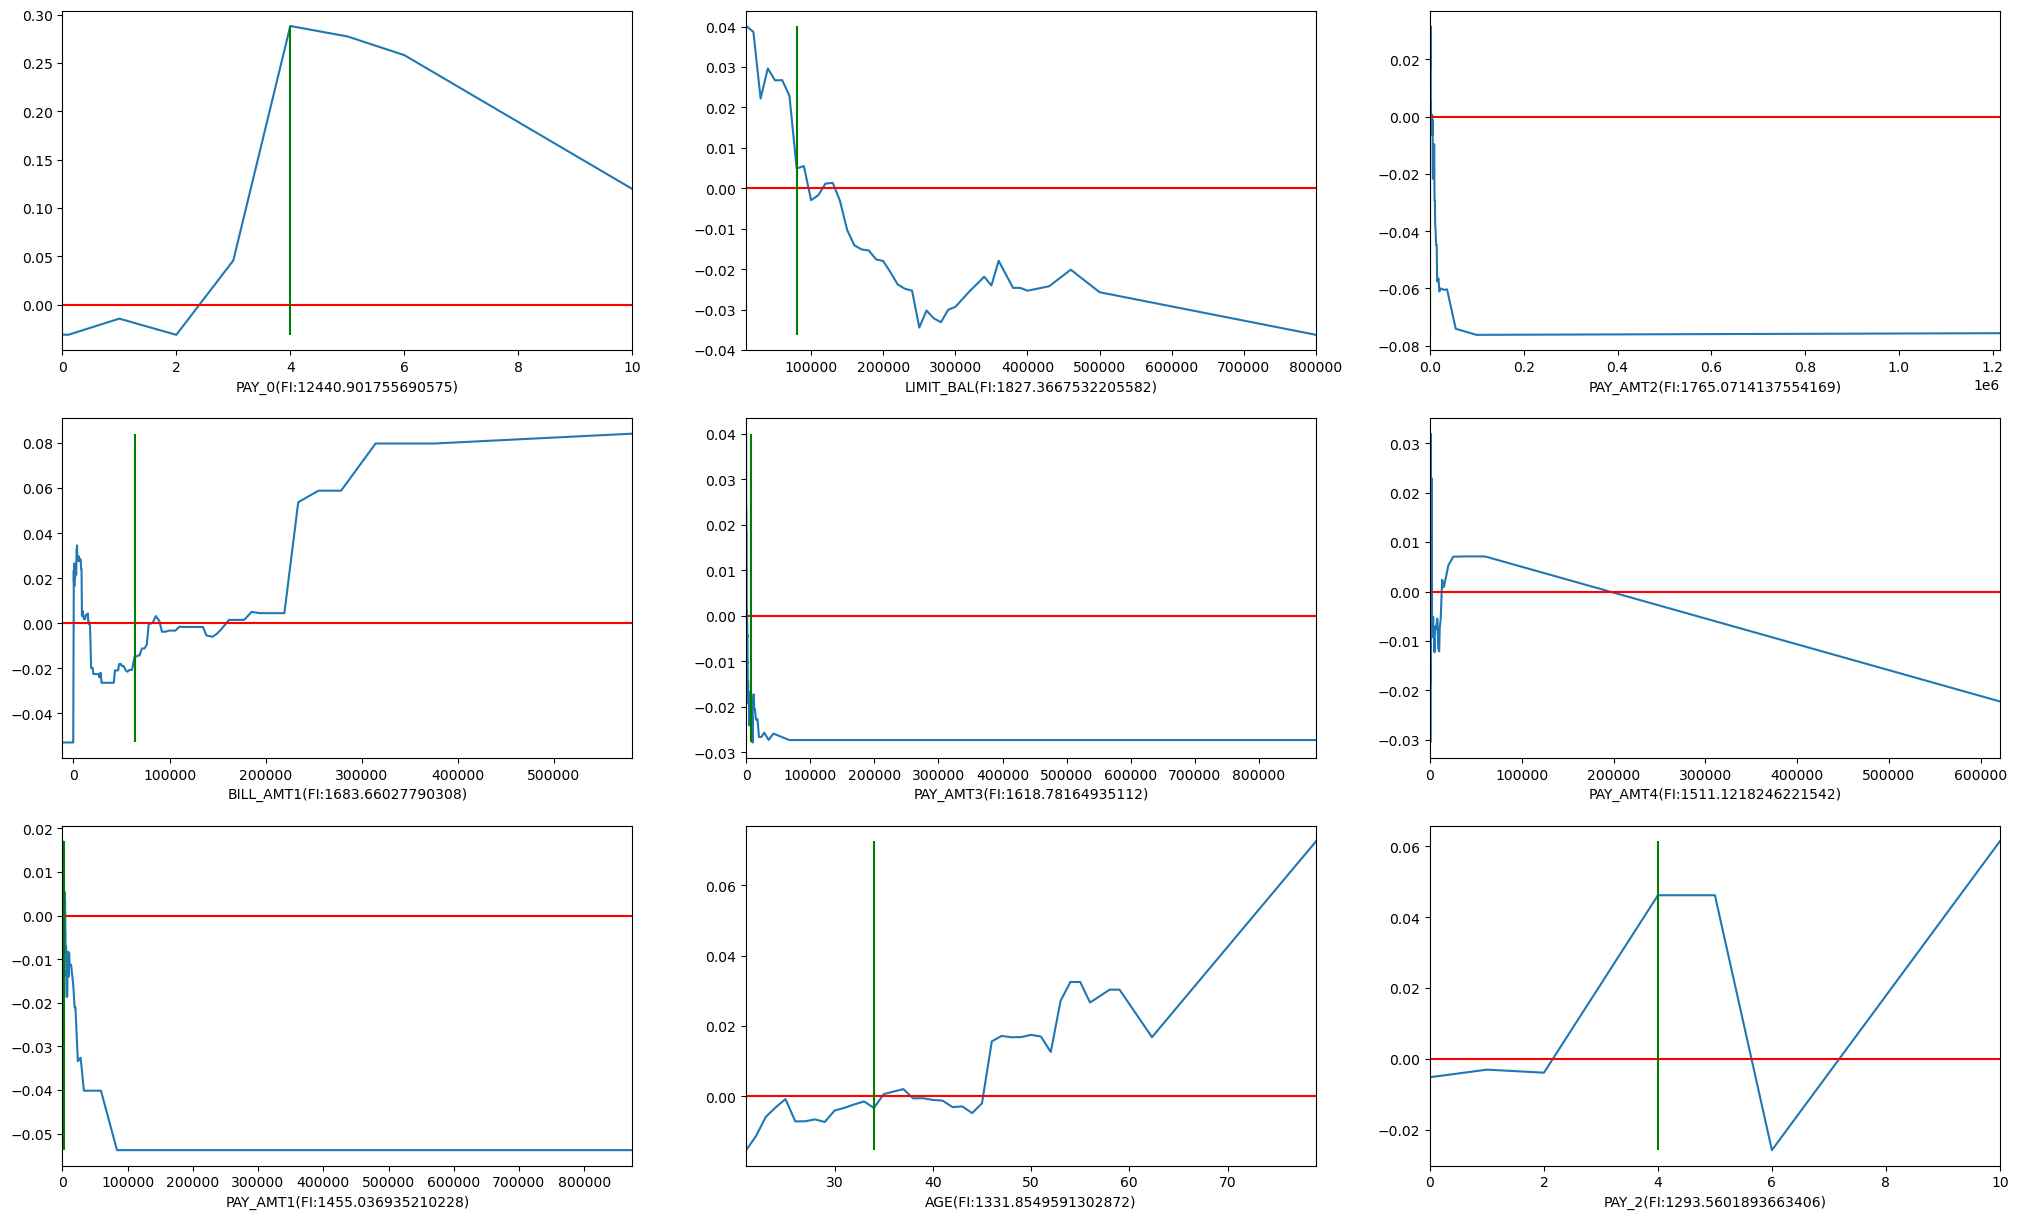

In [62]:
# Control number features to plot
n_ales = 9

# Select based on feature importances
feat_idx = np.argsort(clf.feature_importances_)[-n_ales:][::-1]

# Initialize ALE and get explainers
ale = ALE(predict_proba_numpy, feature_names=X.columns.to_list(), target_names=['0','1'])
ale_exp = ale.explain(X_test.to_numpy())

# Get plot grid size
import math
plot_grid_size = math.floor(math.sqrt(n_ales))

fig, ax = plt.subplots(plot_grid_size, plot_grid_size, figsize=(25, 15))

for i in range(plot_grid_size):
    for j in range(plot_grid_size):
        idx = plot_grid_size*i + j
        ale_val = ale_exp.ale_values[feat_idx[idx]][:,1]
        feat_val = ale_exp.feature_values[feat_idx[idx]]
        feat_name = ale_exp.feature_names[feat_idx][idx]
        
        current_val = X_inf.to_numpy()[inf_id,:][feat_idx[idx]]

        ax[i,j].plot(feat_val, ale_val)
        ax[i,j].hlines(y=0, xmin=feat_val.min(), xmax=feat_val.max(), colors='r')
        ax[i,j].vlines(x=current_val, ymin=ale_val.min(), ymax=ale_val.max(), colors='g')
        ax[i,j].set_xlabel(feat_name+"(FI:"+str(clf.feature_importances_[feat_idx[idx]])+")")
        ax[i,j].set_xlim(feat_val.min(), feat_val.max())
plt.show()

## RIPPER Prediction

In [63]:
rip_pred, reason = rip_exp.predict(X_inf.iloc[[inf_id]],give_reasons=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [64]:
rip_pred[0]

True

In [65]:
reason[0][0]

<Rule [PAY_0=4]>